## Simple CNN network

The original problem is:

    (P) Compute the fabrics from multiple sliced images per rev

We are firstly having an intermediate objective:

    (P') Compute the fabrics from one single sliced images per rev

Of course, the accuracy will be much worse because the fabrics are computed in every direction. However, it is a good try.

# Importing the dataframe

Firstly, we initialize wandb. It is a tool that allows to store the losses and retrieve the deframe. Otherwise, you can directly access locally the dataframe on your computer.

In [ ]:
!pip install wandb --upgrade

We import all the useful packages.

In [2]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("/kaggle/input/microstructure-reconstruction/")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(repo_path)

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

import wandb
from custom_datasets import dataset
from tools import dataframe_reformat, plotting, inspect_code, training, wandb_api

wandb_api.login()

seed = 42
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
print(f"[INFO]: Computation device: {device}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


We initialize a wandb run, that will save our metrics

In [3]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="Naive Network",
    job_type="test",
)


Parameters of our run:

In [4]:
config = wandb.config
config.train_val_split = 0.7
config.seed = 42
config.batch_size = 32
config.learning_rate = 0.01
config.device = device
config.momentum = 0.9
config.architecture = "VGG"
config.input_width = 256
config.weight_decay = 0.0005
config.epochs = 0
config.frac_sample = 1
# config.total_layers = 24
# config.fixed_layers = 0
torch.manual_seed(config.seed)


We retrieve the dataframe containing the descriptors. This can locally be done on your computer.

In [5]:
data_at = run.use_artifact("raw_fabrics" + ":3_images")
data_dir = data_at.download()
fabrics_df = wandb_api.convert_table_to_dataframe(data_at.get("fabrics"))
fabrics_df = fabrics_df.sample(frac=config.frac_sample, random_state=config.seed)
fabrics_df["photos"] = fabrics_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)
fabrics_df.head()


,id,orientation-0_mean,orientation-0_std,orientation-1_mean,orientation-1_std,orientation-2_mean,orientation-2_std,orientation-3_mean,orientation-3_std,orientation-4_mean,...,aspectratio-1_mean,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
110,Spec-199,0.340500,0.321285,0.338215,-0.008812,-0.000788,0.003326,0.304648,0.302155,0.310230,...,0.137878,0.101578,12.758537,3.920147,0.855135,0.093256,0.206649,0.081536,0.347122,[/home/matias/microstructure-reconstruction/RE...
419,Spec-477,0.140781,0.131637,0.727582,0.242003,0.006315,-0.001847,0.154697,0.135059,0.169285,...,0.137516,0.108505,11.281476,2.126035,0.925336,0.074298,0.275651,0.119497,0.091461,[/home/matias/microstructure-reconstruction/RE...
565,Spec-68,0.350577,0.323444,0.325980,0.004078,0.007206,-0.012600,0.308358,0.302684,0.304662,...,0.140101,0.104154,12.878511,3.812330,0.851472,0.098154,0.205729,0.086907,0.407607,[/home/matias/microstructure-reconstruction/RE...
77,Spec-169,0.353518,0.323367,0.323115,-0.002773,0.005499,0.008358,0.314684,0.298870,0.302726,...,0.137758,0.107203,12.924555,4.120053,0.846134,0.105053,0.212573,0.092038,0.415207,[/home/matias/microstructure-reconstruction/RE...
181,Spec-262,0.328198,0.328981,0.342821,-0.007508,-0.024902,0.014861,0.305752,0.303890,0.309204,...,0.140087,0.116953,12.246303,2.920092,0.908055,0.101011,0.277904,0.126039,0.406908,[/home/matias/microstructure-reconstruction/RE...


# Datasets

We create the training and validation dataset from our dataframe of descriptors. 

In [6]:
train_df, test_df = train_test_split(
    fabrics_df,
    train_size=config.train_val_split,
    random_state=config.seed,
    shuffle=True,
)

transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config.input_width, config.input_width)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    ]
)

train_dataset = dataset.SinglePhotoDataset(
    train_df, normalization=True, transform=transform
)
validation_dataset = dataset.SinglePhotoDataset(
    test_df, normalization=[train_dataset.min, train_dataset.max], transform=transform
)


# Network definition

The next step is to define our model. This model is inspired by VGG11:

* we define several convulational blocks.
* each of this block is sequence of:
  * convulational layer with `kernel_size=3, padding=1`
  * activation function, here it is the `ReLU`
  * max pooling layer with `kernel_size=2, stride=2` which aims at reducing the size of the convolutional layers

In [7]:
class VGG11(nn.Module):
    def __init__(self, input_channel, input_height, output_size):
        super(VGG11, self).__init__()
        self.in_channels = input_channel
        self.output_size = output_size
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #             nn.Conv2d(512, 512, kernel_size=3, padding=1),
            #             nn.ReLU(),
            #             nn.Conv2d(512, 512, kernel_size=3, padding=1),
            #             nn.BatchNorm2d(512),
            #             nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        input_fc = int((input_height / (2 ** 5)) ** 2 * 512)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_fc, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=self.output_size),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


model = VGG11(input_channel=1, input_height=config.input_width, output_size=23).to(
    device
)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")


[INFO]: 21,109,399 total parameters.
[INFO]: 21,109,399 trainable parameters.


# Pytorch boilerplate

We then need to define dataloaders, optimizer and our loss.
We take the L1 loss.

In [8]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, **kwargs
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=config.batch_size, shuffle=False, **kwargs
)
loss = nn.L1Loss()
optimizer = optim.SGD(
    model.parameters(),
    lr=config.learning_rate,
    momentum=config.momentum,
    weight_decay=config.weight_decay,
)

config.model_type = type(model)
config.loss_type = type(loss)
config.optimizer_type = type(optimizer)


We check that our first batch looks ok

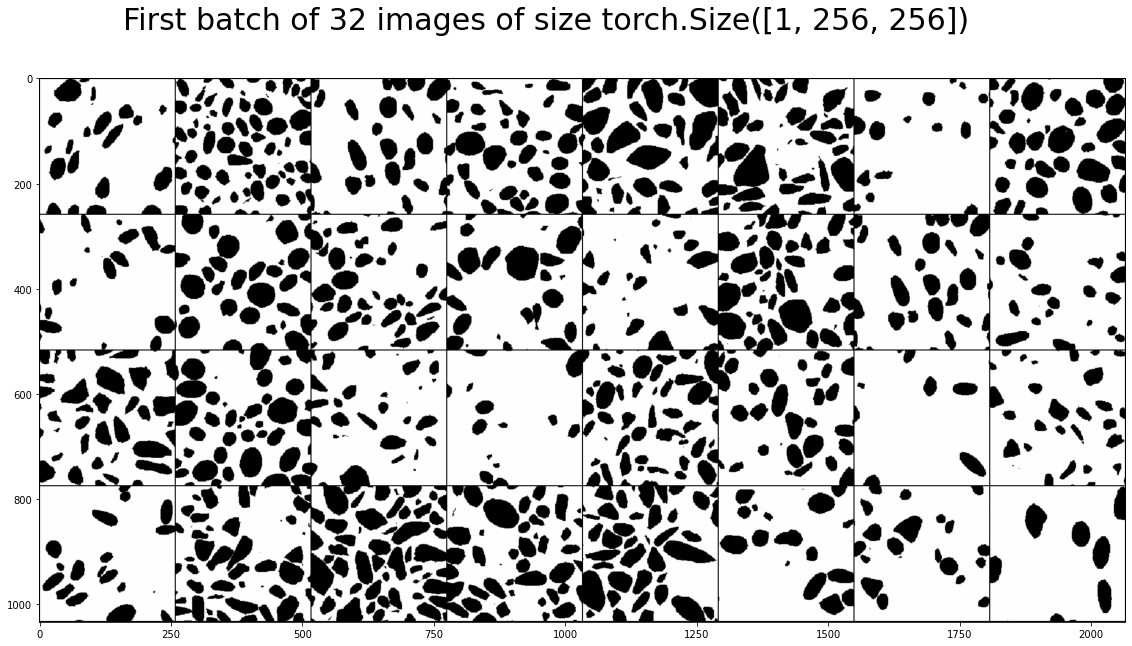

In [9]:
first_batch = next(iter(train_dataloader))
images = first_batch[0]
labels = first_batch[1]
grid = utils.make_grid(images)

fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
fig.suptitle(f"First batch of {config.batch_size} images of size {images[0].shape}", fontsize=30)
plt.show()


# Training

The next step is to train our model

In [29]:
train_loss, val_loss, max_error = [], [], []
nb_epochs = deepcopy(config.epochs)
for epoch in range(nb_epochs, nb_epochs+1):
    current_train_loss = training.train(model, device, train_dataloader, optimizer, loss)
    current_val_loss, _, current_max_error = training.validate(
        model,
        device,
        validation_dataloader,
        loss,
        validation_dataset.min,
        validation_dataset.max,
    )

    train_loss.append(current_train_loss)
    val_loss.append(current_val_loss)
    max_error.append(current_max_error)
    print(
        "{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}".format(
            "Epoch",
            epoch,
            "train loss",
            current_train_loss,
            "val loss",
            current_val_loss,
            "max error",
            current_max_error,
        )
    )
    if epoch >= 1:
        wandb.log(
            {
                "train_loss": current_train_loss,
                "val_loss": current_val_loss,
                "max_error": current_max_error,
                "epoch": epoch,
            }
        )
        config.epochs = epoch


  0%|          | 0/119 [00:00<?, ?it/s]

In [ ]:
outputs, targets = training.compute_outputs(model, device, validation_dataloader)
predictions = outputs.cpu().numpy()
targets = targets.cpu().numpy()

In [ ]:
fig, axs = plotting.plot_hist(targets, predictions, 2, columns=test_df.columns[1:-1])

In [10]:
wandb_api.add_writeable_object(run, inspect_code.get_class_code(type(model)), "model_script")
run.finish()